# Changes from Model v1.0 (Score 2.3680)

Updating the parameters for XKB from:

``` python
xgb_base_model = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42,
)
```

to

``` python
xgb_base_model = XGBRegressor(
    alpha=1.6728374329132103,
    colsample_bytree=0.9,
    gamma=0.1,
    reg_lambda=20.0,
    learning_rate=0.05,
    max_depth=10,
    min_child_weight=7,
    n_estimators=5000,
    subsample=0.8,
    objective='reg:squarederror',
    random_state=42,
)
```

**Result Score: 2.3806**

Conclusion:

* The RMSEs of out train/test splits are great and seem to be improving a lot the predictions.
* This is not the case. I think we have here a overfitting problem.  

# Create a baseline model

In [1]:
import pandas as pd

from data import load_data_selected_features

train_data, additional_train_data, test_data = load_data_selected_features()

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150996 entries, p01_0 to p12_25298
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 585.2+ MB


In [3]:
additional_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168588 entries, p01_test_12 to p24_test_94938
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 657.4+ MB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3644 entries, p01_8459 to p24_260
Columns: 506 entries, p_num to activity-0:00
dtypes: float64(432), object(74)
memory usage: 14.2+ MB


# Prepare the data

In [5]:
from pipelines_selected_features import pipeline

all_train_data = pd.concat([train_data, additional_train_data], axis=0)
all_train_data_transformed = pipeline.fit_transform(all_train_data)

train_data_transformed = all_train_data_transformed[:len(train_data)]
additional_train_data_transformed = all_train_data_transformed[len(train_data):]

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

X_additional_train = additional_train_data_transformed.drop(columns=['bg+1:00'])
y_additional_train = additional_train_data_transformed['bg+1:00']

## Create the model

In [6]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LassoLarsIC, Ridge

hgb_estimator = HistGradientBoostingRegressor(
    l2_regularization=0.0001,
    learning_rate=0.1,
    max_depth=11,
    max_iter=1500,
    min_samples_leaf=10,
    n_iter_no_change=22,
    random_state=42,
)

lasso_lars_ic_base_model = LassoLarsIC(
    criterion='aic',
    eps=0.03922948513965659,
    max_iter=1944,
    noise_variance=5.4116687755186035e-05,
    positive=False,
)
knn_base_model = KNeighborsRegressor(n_neighbors=5)

xgb_base_model = XGBRegressor(
    alpha=1.6728374329132103,
    colsample_bytree=0.9,
    gamma=0.1,
    reg_lambda=20.0,
    learning_rate=0.05,
    max_depth=10,
    min_child_weight=7,
    n_estimators=5000,
    subsample=0.8,
    objective='reg:squarederror',
    random_state=42,
)

estimators = [
    ('hgb', hgb_estimator),
    ('lasso_lars_ic', lasso_lars_ic_base_model),
    ('knn', knn_base_model),
    ('xgb', xgb_base_model),
]

model = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=0.1), n_jobs=-1, verbose=2)

11:09:49 - 11:09:49 - Start training
11:09:49 - 11:09:49 - Calculate performance for hgb
11:09:49 - 11:09:49 - Splitting the additional train data with ShuffleSplit
11:09:49 - 11:09:49 - Split 1 - Model: hgb
11:09:49 - 11:09:49 - Fitting the model
11:10:50 - 11:10:50 - Predicting
11:10:51 - 11:10:51 - Calculating scores
11:10:52 - 11:10:52 - R^2: 0.6802980598686639, RMSE: 1.853234323545247, MAE: 1.3781103796392653, MSE: 3.4344774579662096
11:10:52 - 11:10:52 - Split 2 - Model: hgb
11:10:52 - 11:10:52 - Fitting the model
11:11:59 - 11:11:59 - Predicting
11:11:59 - 11:11:59 - Calculating scores
11:12:00 - 11:12:00 - R^2: 0.6790084797635141, RMSE: 1.8599546082369873, MAE: 1.389380261014941, MSE: 3.4594311447020054
11:12:00 - 11:12:00 - Split 3 - Model: hgb
11:12:00 - 11:12:00 - Fitting the model
11:13:00 - 11:13:00 - Predicting
11:13:01 - 11:13:01 - Calculating scores
11:13:01 - 11:13:01 - R^2: 0.6768352388557501, RMSE: 1.8473604416799103, MAE: 1.3794091734729261, MSE: 3.4127406014837933


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.8min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 10.1min remaining: 15.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.1min finished


11:46:38 - 11:46:38 - Predicting
11:46:50 - 11:46:50 - Calculating scores
11:47:02 - 11:47:02 - R^2: 0.755234801892537, RMSE: 1.6215581715453231, MAE: 1.1726656817428713, MSE: 2.6294509037054117
11:47:02 - 11:47:02 - Split 2 - Model: stacking_regressor
11:47:02 - 11:47:02 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.1s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.2min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 10.7min remaining: 16.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.8min finished


12:05:18 - 12:05:18 - Predicting
12:05:31 - 12:05:31 - Calculating scores
12:05:44 - 12:05:44 - R^2: 0.7539011366720175, RMSE: 1.628584771829905, MAE: 1.1860175195234133, MSE: 2.6522883590362634
12:05:44 - 12:05:44 - Split 3 - Model: stacking_regressor
12:05:44 - 12:05:44 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.2s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.0min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 10.3min remaining: 15.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.4min finished


12:23:04 - 12:23:04 - Predicting
12:23:15 - 12:23:15 - Calculating scores
12:23:26 - 12:23:26 - R^2: 0.7547252667537376, RMSE: 1.6094075958906235, MAE: 1.1689663078946384, MSE: 2.590192809710437
12:23:26 - 12:23:26 - Split 4 - Model: stacking_regressor
12:23:27 - 12:23:27 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.7s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.8min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  9.4min remaining: 14.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.5min finished


12:39:55 - 12:39:55 - Predicting
12:40:06 - 12:40:06 - Calculating scores
12:40:18 - 12:40:18 - R^2: 0.7527245873466188, RMSE: 1.634804971107928, MAE: 1.1871716158968093, MSE: 2.672587293559193
12:40:18 - 12:40:18 - Split 5 - Model: stacking_regressor
12:40:18 - 12:40:18 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.5min remaining:  5.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  9.2min remaining: 13.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.3min finished


12:56:19 - 12:56:19 - Predicting
12:56:30 - 12:56:30 - Calculating scores
12:56:41 - 12:56:41 - R^2: 0.7497369849889548, RMSE: 1.6238252577001977, MAE: 1.1799665694359394, MSE: 2.6368084675451136
12:56:41 - 12:56:41 - Training finished


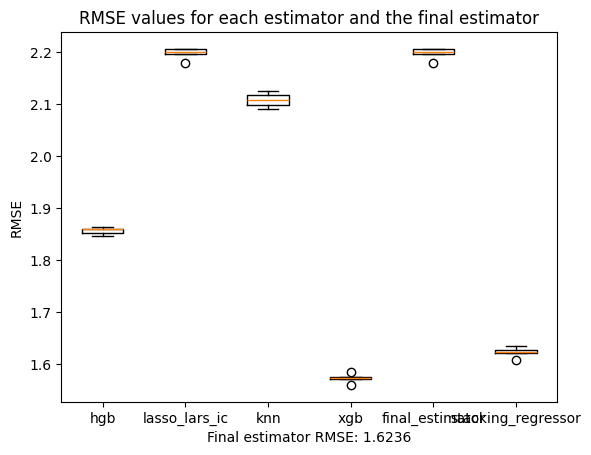

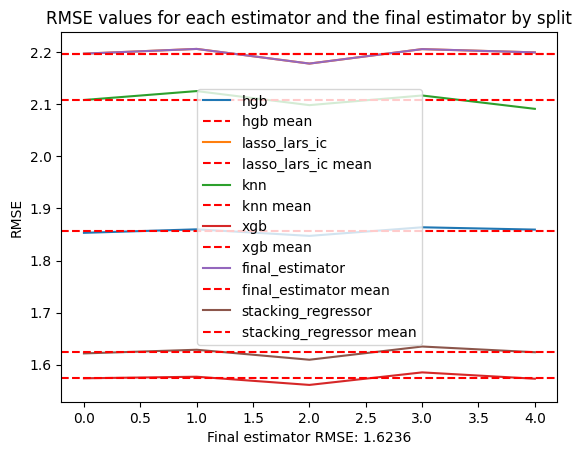

In [7]:
from datetime import datetime
import os
from model_performance_calculations import calculate_stacking_regressor_performance, get_rmse_boxplot_chart, get_rmse_line_chart, save_performances, save_model

date_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_name = f'{date_time}-model-stacking-tuned-LLIC-HGB-XGB'

save_model(model, os.path.join('models', f'{model_name}.pkl'))

performances = calculate_stacking_regressor_performance(model, X_train, y_train, X_additional_train, y_additional_train)
save_performances(performances, os.path.join('models', f'{model_name}-performances.json'))

get_rmse_boxplot_chart(performances).show()
get_rmse_line_chart(performances).show()

## Predict test data

In [8]:
import numpy as np
from pipelines_selected_features import pipeline

all_train_data_transformed = pipeline.fit_transform(pd.concat([train_data, additional_train_data], axis=0))
X_train = all_train_data_transformed.drop(columns=['bg+1:00'])
y_train = all_train_data_transformed['bg+1:00']

model.fit(X_train, y_train)

X_test = pipeline.transform(test_data)

y_pred = model.predict(X_test)

if np.sum(y_pred < 0) > 0:
    print(f'Number of negative values: {np.sum(y_pred < 0)}')
    bg_min_train = np.min(y_train)
    print(f'Min value: {np.min(y_pred)}')
    print(f'Filling negative values with {bg_min_train}')
    y_pred = np.where(y_pred < 0, bg_min_train, y_pred)

test_data['bg+1:00'] = y_pred
test_data.head()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.0s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.0min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 10.4min remaining: 15.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.6min finished


,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,p01,06:45:00,NaN,9.2,NaN,NaN,10.2,NaN,NaN,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.956626
p01_8460,p01,11:25:00,NaN,NaN,9.9,NaN,NaN,9.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Walk,Walk,Walk,5.845557
p01_8461,p01,14:45:00,NaN,5.5,NaN,NaN,5.5,NaN,NaN,5.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.172315
p01_8462,p01,04:30:00,NaN,3.4,NaN,NaN,3.9,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.718219
p01_8463,p01,04:20:00,NaN,NaN,8.3,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.746614


In [9]:
submission = pd.DataFrame(test_data['bg+1:00'])
submission

,bg+1:00
id,
p01_8459,8.956626
p01_8460,5.845557
p01_8461,8.172315
p01_8462,10.718219
p01_8463,6.746614
...,...
p24_256,6.229122
p24_257,10.008119
p24_258,6.360583


In [10]:
submission.to_csv(f'submission-{model_name}.csv')